In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras_core as keras
import torch

Using PyTorch backend.


In [2]:
# Set the directory path where the CSV files are located
directory_path = 'data/labeled/'

# Get a list of CSV files in the directory
csv_files = [file for file in os.listdir(directory_path)]

# Load each CSV file into a DataFrame and store them in a list
dataframes_list = []
for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes_list.append(df)

dataset = pd.concat(dataframes_list, ignore_index=True)

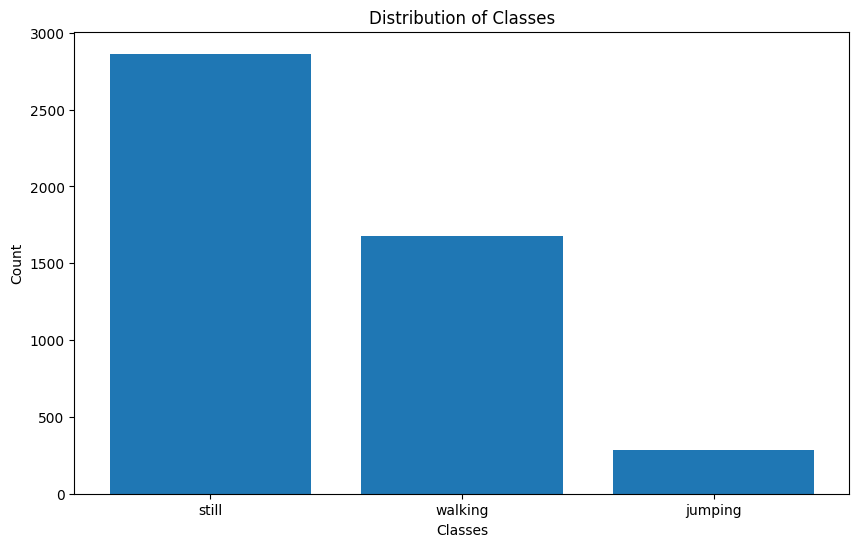

In [3]:
labels_counts = dataset['labels'].value_counts()

# Assuming 'labels_counts' is the Series containing the counts of each class
plt.figure(figsize=(10, 6))

# Plotting the histogram
plt.bar(labels_counts.index, labels_counts.values)

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Classes')

plt.show()

In [4]:
dataset.head(5)

,x,y,z,labels
0,-0.404321,-9.855731,-0.435146,still
1,-0.404321,-9.855731,-0.435146,still
2,-0.267851,-9.709685,0.247201,still
3,-0.342072,-9.740809,-0.650624,still
4,-0.835277,-9.824607,0.163404,still


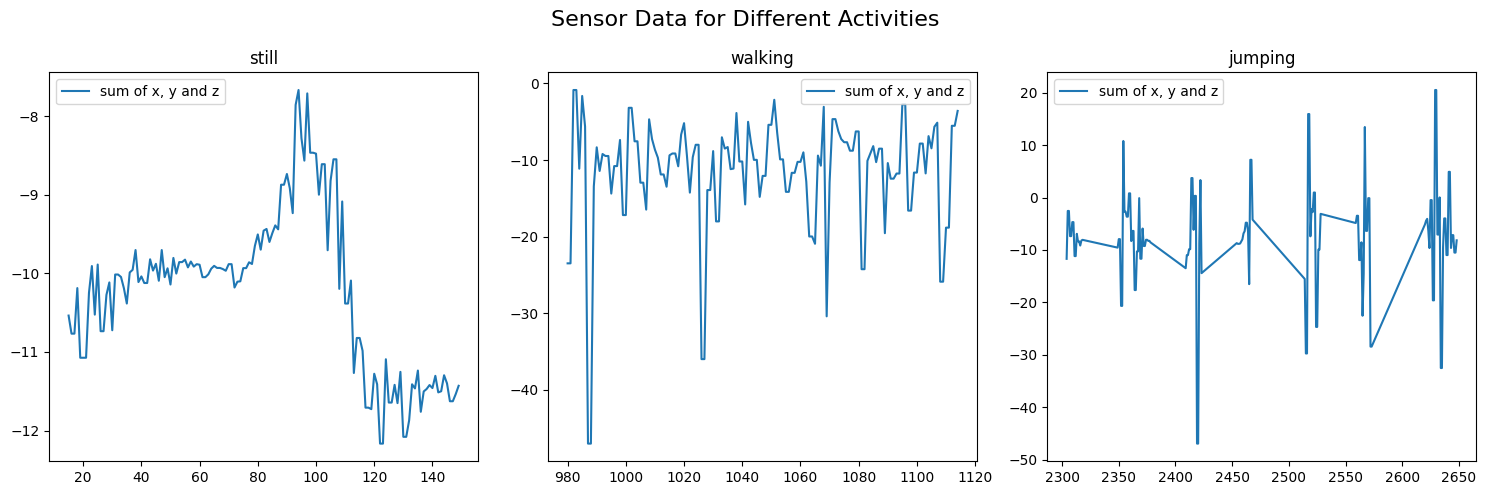

In [5]:
# unique labels
labels = dataset['labels'].unique()

# Create subplots with 1 row and 3 columns for each label
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Loop through each label and plot the first 100 values
for i, label in enumerate(labels):
    subset_df = dataset[dataset['labels'] == label].iloc[15:150]
    axes[i].plot(subset_df.iloc[:, :3].sum(1), label='sum of x, y and z')
    axes[i].set_title(label)
    axes[i].legend()

# Add a common title for all subplots
fig.suptitle('Sensor Data for Different Activities', fontsize=16)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, window_size=28, shift_percentage=0.25):
        self.data = dataset
        self.window_size = window_size
        self.shift_size = int(window_size * shift_percentage)
        self.labels = self.data.iloc[:, -1].values
        self.labels = np.expand_dims(self.labels, axis=1)
        self.data = self.data.iloc[:, :-1].values
        self.ohe = OneHotEncoder(sparse_output=False)
        self.ohe.fit(self.labels)

    def __len__(self):
        return (len(self.data) - self.window_size) // self.shift_size + 1

    def __getitem__(self, idx):
        start_idx = idx * self.shift_size
        end_idx = start_idx + self.window_size

        inputs = self.data[start_idx:end_idx]
        labels = [self.labels[end_idx-1]]

        # Convert the label to one-hot encoding
        one_hot_label = self.ohe.transform(labels)
        one_hot_label = np.squeeze(one_hot_label)

        return torch.tensor(inputs, dtype=torch.float32), one_hot_label

In [7]:
import math

test_split = 0.0
split_indx = math.ceil(len(dataset) * (1 - test_split))

train_df, test_df = dataset[:split_indx], dataset[split_indx:]
print(len(train_df), len(test_df))

4826 0


In [8]:
BATCH_SIZE = 64

train_ds = Dataset(train_df, 14, 0.25)
# test_ds = Dataset(test_df, 42, 0.125)

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True)
# test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE)

In [11]:
model = keras.Sequential([
    keras.layers.LSTM(32, activation='tanh'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [12]:
history = model.fit(train_dl, epochs=10)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5078 - loss: 0.9329
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6528 - loss: 0.7011
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7661 - loss: 0.5958
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8863 - loss: 0.3861
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9055 - loss: 0.2929
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9145 - loss: 0.2791
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9333 - loss: 0.2246
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9400 - loss: 0.2097
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9425 - loss: 0.1852
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9490 - loss: 0.1632


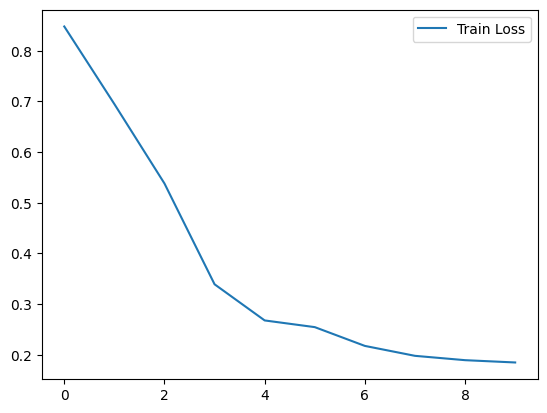

In [13]:
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [14]:
y_true = []
y_pred = []

for data in train_dl:
    y_pred.append(model.predict(data[0]))
    y_true.append(data[1])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [15]:
y_true_concat = np.vstack(y_true)
y_pred_concat = np.vstack(y_pred)

y_true_concat = np.argmax(y_true_concat, -1)
y_pred_concat = np.argmax(y_pred_concat, -1)
print(y_true_concat.shape, y_pred_concat.shape)

(1605,) (1605,)


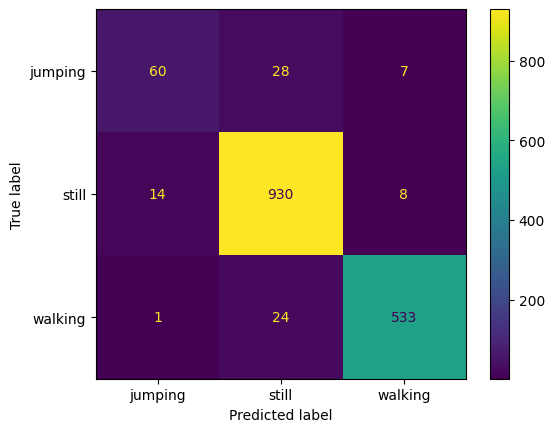

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_concat, y_pred_concat)
display = ConfusionMatrixDisplay(
    cm, display_labels=['jumping', 'still', 'walking'])
display.plot()
plt.show()

In [17]:
model.save('models/model_01.keras')